In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import numpy as np
from pathlib import Path

# Code for getting usefull EnergyPlan `input`-data

Here I clean the KF- and EnergyDataService data.

## 1. KF-data

### 1.1 Production

In [2]:
timeseries = ['Solceller','Landvind','Havvind','Timepriser']

for t in timeseries:

    # 0. read
    df = pd.read_excel('0_KF_data/KF25 Elsystem -  timedata (4).xlsx', sheet_name=t)

    # 1. clean
    col1 = df.iloc[0].astype(str)
    col2 = df.iloc[1].astype(str)
    df.columns = col1 + "_" + col2
    df = df.iloc[2:].reset_index(drop=True)

    # 2. select year columns
    years = df.columns.str.extract(r'(\d{4})$', expand=False)
    df2 = df.loc[:, years.notna()].copy()
    years2 = years[years.notna()]

    if t == 'Timepriser':
        weights = np.array([0.6, 0.4])
        df_year = pd.DataFrame(index=df2.index)
        for y in years2.unique():
            cols_y = df2.columns[years2 == y]
            df_year[y] = df2[cols_y].values @ weights[:len(cols_y)] 
            df_year = df_year / 7.5  # adjust to EUR/MWh
    else:
        df_year = df2.groupby(years2, axis=1).sum()

    # 3. keep only 2035
    df_2035 = df_year[['2035']]

    # 4. add first 24 to end (energyplan-format)
    # df_2035.iloc[-31*24:] = df_2035.iloc[:31*24].to_numpy() # december=january
    df_2035 = pd.concat([df_2035, df_2035.iloc[0:24]], ignore_index=True)

    # 5. save as .txt
    df_2035.to_csv(
        r'..\ZipEnergyPLAN163\energyPlan Data\Distributions\KF25_2035_' + t + '.txt',
        sep='\t',
        index=False,
        header=False,
    )

C:\Users\LinusLindquist\AppData\Local\Temp\ipykernel_16868\4160489111.py:27: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_year = df2.groupby(years2, axis=1).sum()
C:\Users\LinusLindquist\AppData\Local\Temp\ipykernel_16868\4160489111.py:27: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_year = df2.groupby(years2, axis=1).sum()
C:\Users\LinusLindquist\AppData\Local\Temp\ipykernel_16868\4160489111.py:27: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_year = df2.groupby(years2, axis=1).sum()


## 2. EnergyDataService

From EDS I download 'Electricity demand' and 'External Electricity Market price distribution' for 2024 initially.

### 2.1 Elspot price

In [2]:
# 0. get using API
BASE = "https://api.energidataservice.dk/dataset/Elspotprices"

params = {
    "start":    "2024-01-01T00:00",             
    "end":      "2025-01-01T00:00",
    "timezone": "UTC",                       
    "filter":   '{"PriceArea":["DK1","DK2"]}',              # Q til FL
    "columns":  "HourUTC,HourDK,PriceArea,SpotPriceEUR",
    "sort":     "HourUTC asc",
    "limit":    0                                    
}

r = requests.get(BASE, params=params, timeout=60)
r.raise_for_status()
df = pd.DataFrame(r.json().get("records", []))
df["HourUTC"] = pd.to_datetime(df["HourUTC"])

# 1. conpute average
df_avg = (
    df.groupby("HourUTC")["SpotPriceEUR"]
      .mean()
      .to_frame("SpotPriceEUR")   # keep as DataFrame
)

# 2. extract year of first row from the index
year = df_avg.index[0].year

# 3. save as .txt
df_avg.to_csv(
    fr'..\ZipEnergyPLAN163\energyPlan Data\Distributions\{year}_ENS_elspotprices.txt',
    sep='\t',
    index=False,
    header=False,
)

OSError: Cannot save file into a non-existent directory: '..\ZipEnergyPLAN163\energyPlan Data\Distributions'

In [ ]:
df_avg

### 2.2 Demand distribution

In [4]:
# 0. get using API
BASE = "https://api.energidataservice.dk/dataset/ProductionConsumptionSettlement"

params = {
    "start":    "2024-01-01T00:00",             
    "end":      "2025-01-01T00:00",
    "timezone": "UTC",                       
    "columns":  "HourUTC,PriceArea,GrossConsumptionMWh",
    "sort":     "HourUTC asc",
    "limit":    0                                    
}

r = requests.get(BASE, params=params, timeout=60)
r.raise_for_status()
df = pd.DataFrame(r.json().get("records", []))
df["HourUTC"] = pd.to_datetime(df["HourUTC"])

# 1. sum for DK
df_dk = df.groupby("HourUTC")["GrossConsumptionMWh"].sum().to_frame("GrossConsumptionMWh")

# 2. extract year of first row from the index
year = df_dk.index[0].year

# 3. save as .txt
df_dk.to_csv(
    fr'..\ZipEnergyPLAN163\energyPlan Data\Distributions\{year}_ENS_ProductionConsumptionSettlement.txt',
    sep='\t',
    index=False,
    header=False,
)

## Sanity of distributions loaded into EnrgyPLAN 

Build df with all distributions:

In [5]:
# 1. KF data
timeseries = ['Solceller', 'Landvind', 'Havvind', 'Timepriser']
base = Path(r'..\ZipEnergyPLAN163\energyPlan Data\Distributions')

df_list = []    

for t in timeseries:
    fpath = base / f"KF25_2035_{t}.txt"
    
    s = pd.read_csv(
        fpath,
        sep="\t",
        header=None,
        names=[t],             
    )
    s["hour"] = range(1, len(s) + 1) 
    df_list.append(s)

# merge KF series into one df
df_KF = df_list[0]
for s in df_list[1:]:
    df_KF = df_KF.merge(s, on="hour", how="left")


# 2. ENS data
ens_path = base / "2024_ENS_ProductionConsumptionSettlement.txt"

df_ENS = pd.read_csv(
    ens_path,
    sep="\t",
    header=None,
    names=["GrossConsumptionMWh"],
)
df_ENS["hour"] = range(1, len(df_ENS) + 1)
df_ENS = df_ENS[["hour", "GrossConsumptionMWh"]]


# 3. combine KF + ENS
df_all = df_KF.merge(df_ENS, on="hour", how="left")
df_all = df_all[["hour"] + timeseries + ["GrossConsumptionMWh"]]

Plot with hours on first axis:

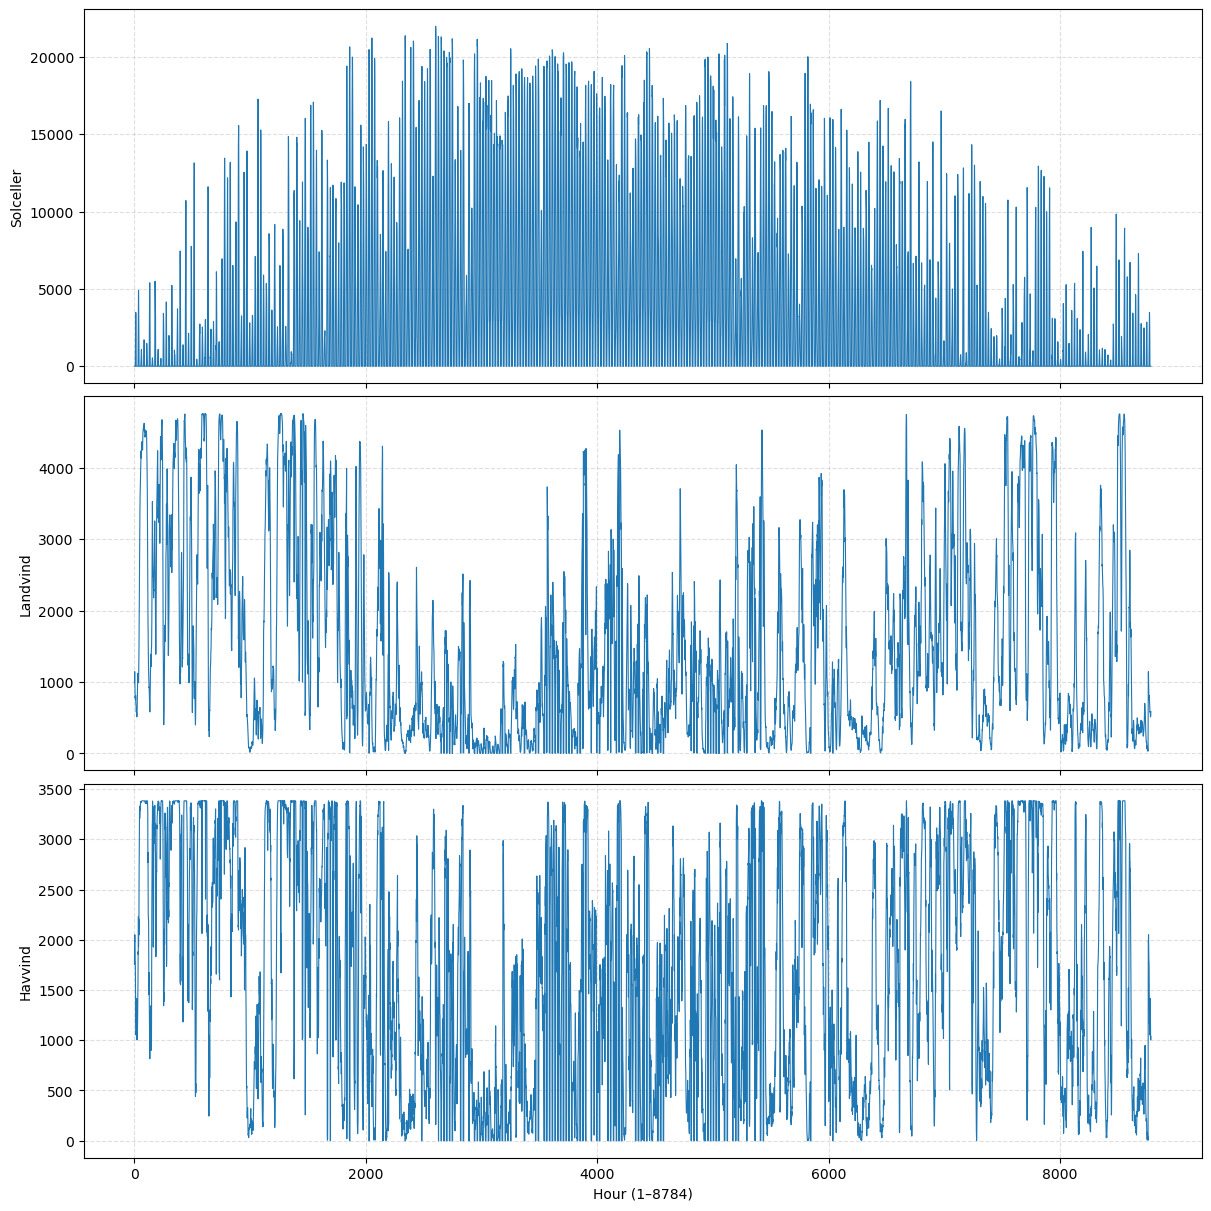

In [6]:
cols_to_plot = ["GrossConsumptionMWh",'Solceller', 'Landvind', 'Havvind', 'Timepriser']
cols_to_plot = ['Solceller', 'Landvind', 'Havvind']

n_series = len(cols_to_plot)

fig, axes = plt.subplots(
    nrows=n_series,
    ncols=1,
    figsize=(12, 12),
    sharex=True,
    constrained_layout=True,
)

if n_series == 1:
    axes = [axes]  # ensure iterable

x = df_all["hour"]

for ax, col in zip(axes, cols_to_plot):
    ax.plot(x, df_all[col], linewidth=0.8)
    ax.set_ylabel(col)
    ax.grid(True, which="both", linestyle="--", alpha=0.4)

axes[-1].set_xlabel("Hour (1–8784)")

plt.show()

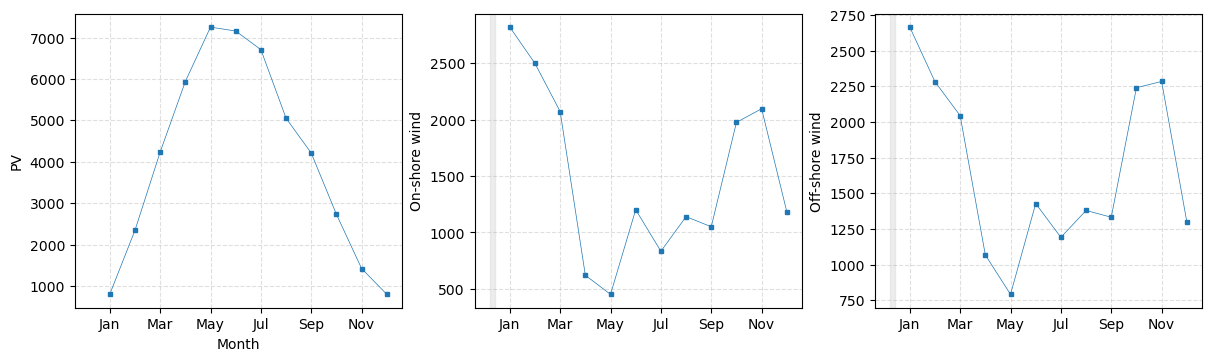

In [7]:
# 1. adapt to months
start = pd.Timestamp('2035-01-01 00:00:00')
df_all['timestamp'] = start + pd.to_timedelta(df_all['hour'] - 1, unit='h')
df_all['month'] = df_all['timestamp'].dt.month

# 2 average by month
monthly = (
    df_all
    .groupby("month", as_index=False)[cols_to_plot]
    .mean()
)

# 3. plot
n_series = len(cols_to_plot)

fig, axes = plt.subplots(
    nrows=1,
    ncols=n_series,
    figsize=(12, 3.5),
    sharex=True,
    constrained_layout=True,
)

if n_series == 1:
    axes = [axes]

x = monthly["month"]

for ax, col in zip(axes, cols_to_plot):
    ax.plot(x, monthly[col], marker="s", markersize=3, linewidth=0.5)
    ax.set_ylabel(col)
    ax.grid(True, which="both", linestyle="--", alpha=0.4)

# x-axis formatting
ticks = np.arange(1, 13, 2)  # 1,3,5,7,9,11
labels = ["Jan", "Mar", "May", "Jul", "Sep", "Nov"]

for ax in axes:
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels)

axes[0].set_xlabel("Month") 
axes[0].set_ylabel('PV')
axes[1].set_ylabel('On-shore wind')
axes[2].set_ylabel('Off-shore wind')

axes[1].axvspan(0.2, 0.4, color="lightgray", alpha=0.4)
axes[2].axvspan(0.2, 0.4, color="lightgray", alpha=0.4)